<h1> Models </h1>

This python notebook describes the methods used for fitting gRNA:dCas9-mxi1 repression cascades to experimental data to by used in the Klavin's Lab *Gander et. al. 2015* publication.

Author: Justin Vrana

Date: 9-9-15

<h2> Model Equations </h2>


|                    |         $\frac{dr_0}{dt}$         | $\frac{dr_1}{dt}$                 | $\frac{dr_2}{dt}$                 | $\frac{dr_3}{dt}$                 | $\frac{dr_4}{dt}$ |
|--------------------|:---------------------------------:|-----------------------------------|-----------------------------------|-----------------------------------|-------------------|
| **Layer 1 (6059)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $u_0 - β r_1$                     |                                   |                                   |                   |
| **Layer 2 (6325)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $\frac{a_1}{1+k_1 r_2^n} - β r_1$ | $u_1 - β r_2$                     |                                   |                   |
| **Layer 3 (6326)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $\frac{a_1}{1+k_1 r_2^n} - β r_1$ | $\frac{a_2}{1+k_2 r_3^n} - β r_2$ | $u_2 - β r_3$                     |                   |
| **Layer 4 (6327)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $\frac{a_1}{1+k_1 r_2^n} - β r_1$ | $\frac{a_2}{1+k_2 r_3^n} - β r_2$ | $\frac{a_3}{1+k_3 r_4^n} - β r_3$ | $u_3 - β r_4$     |


| Parameter | Meaning                                              |
|-----------|------------------------------------------------------|
| a         | promoter strength                                    |
| k         | repression binding strength and respression strength |
| b         | degradation/dilution of gRNA:dCas9-mxi1              |
| u         | maximum induction of pGALZ4:Zev4 promoter            |
| n         | hill-coefficient                                     |
| $r_0$     | output gRNA in cascade                                 |

<h4> Kinetic and Steady-State Model Functions </h4>

In these plots, the resulting values the first index represents the final output gRNA, while the last index represents the first input gRNA, as displayed in the plot above.

In [1]:
import numpy as np
from scipy import integrate
from scipy import optimize
import pylab as plt
import pandas as pd
%matplotlib inline
from IPython import display

def cascade_kinetics(t, r, a, k, b, u, n):
    layer_depth = len(r) - 1
    dR = [0] * len(r)
    dR[layer_depth] = u[layer_depth-1] - b * r[layer_depth]
    for l in range(layer_depth)[::-1]:
        dR[l] = a[l] / (1+k[l] * r[l+1] ** n) - b * r[l]
    return dR

def cascade_ss(layer_depth, a, k, b, u, n):
    assert len(a) == len(k) == len(u)
    assert len(a) >= layer_depth
    u = u[layer_depth-1]
    R = [0]*(layer_depth+1)
    R[layer_depth] = u/b
    for l in range(layer_depth)[::-1]:
        R[l] = a[l] / ((1+k[l] * R[l+1] ** n)*b)
    return R

def tfxn(inducer_at_max, inducer):
    AB = 542.8745566
    K = 0.269635359
    n = 1.238933919
    def fxn(u):
        return (AB*K*u**n)/(1+K*u**n)
    rel_induction = fxn(inducer)/fxn(inducer_at_max)
    return rel_induction

t_final = 75.
dt = 1.0
def integrateSystem(numlayers, a, k, b, u, n):
    ss = cascade_ss(numlayers, a, k, b, np.zeros(len(a)), n)
    r1 = integrate.ode(cascade_kinetics)
    r1.set_initial_value(ss).set_f_params(a, k, b, u, n)
    data1 = []
    while r1.successful() and r1.t < t_final:
        r1.integrate(r1.t+dt)
        data1.append( [r1.t] + list(r1.y) )
    return data1

<h4> Plotting Kinetics Model </h4>

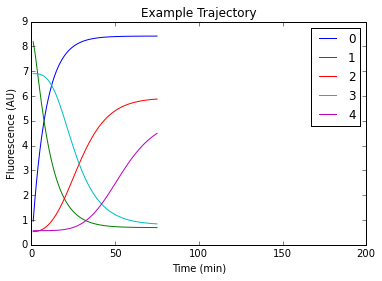

In [2]:
a = [1.0, 1.1, 1.2, 2.4]
k = [0.6, 0.65, 0.7, 0.8]
b = 0.12
u = [0.9, 0.85, 0.95, 1.01]
n = 1.445
params = [a, k, b, u, n]

def kineticsModel(a, k, b, u, n):
    assert len(a) == len(k) == len(u)
    num_layers = len(a)+1
    layers = {}
    time = []
    for l in range(num_layers):
        system = integrateSystem(l, a, k, b, u, n)
        unzipped = zip(*system)
        layers[l] = unzipped[1]
        time = unzipped[0]
    return pd.DataFrame(layers, index=time)

combined = kineticsModel(*params)

plt.figure()
combined.plot()
plt.xlim(0, 200)
plt.xlabel("Time (min)")
plt.ylabel("Fluorescence (AU)")
plt.title("Example Trajectory")
plt.legend(loc="best")
def getValue(t, df):
    i = np.abs(df.index - t).argmin()
    return df.iloc[i]

<h2> Steady State</h2>

<h3> Beta-estradiol transfer function </h3>
r_0 is the output of the GalZ:Zev4 activatable promoter, u is the beta-estradiol

$ r_0 = \frac{A K u^n}{B (1+K u^n)} $ 

$ \frac{dr_0}{dt} = \frac{A K u^n}{1+K u^n} - B r_0 $

$ \frac{A}{B} = 542.8745566$,
$ K = 0.269635359$,
$ n = 1.238933919$

**Insert Transfer Function Data Here! **
 
<h3> Steady State Equations </h3>
Derived from kinetic model above...

<h4> Plotting Steady State Model </h4>

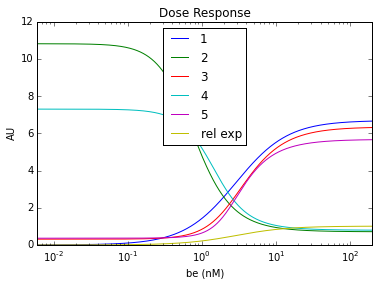

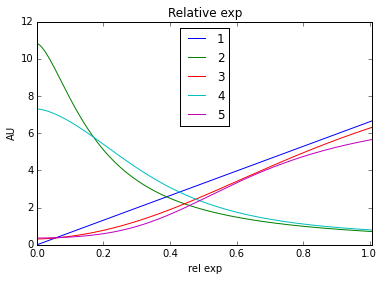

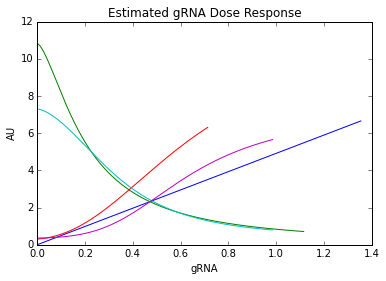

In [3]:
params = [1.85247556,  1.325424,    2.35268847,  1.6003237,   0.14792434,  0.68840386,
  0.41109531,  0.44726091,  0.43802356,  1.34453302,  1.10706773,  0.70852556,
  0.97811609,  1.56968898]
a = params[:4][::-1]
k = params[5:9][::-1]
b = params[4]
u = np.array(params[9:13])
n = params[13]
params = [a, k, b, u, n]

def ssModel(i_array, a, k, b, u, n):
    assert len(a) == len(k) == len(u)
    num_layers = len(a)+1
    dose = pd.DataFrame(index = i_array, columns = list(range(1,num_layers+1)) + ['rel exp'])
    for i in i_array:
        rel_exp = tfxn(100.0, i)
        rel_u = rel_exp * u
        dose.loc[i] = [cascade_ss(l, a, k, b, rel_u, n)[0] for l in range(num_layers)] + [rel_exp]
    return dose

dose = ssModel(0.006 * 2 ** np.linspace(0,15,1000), *params)
# Inducer Dose Response
ax = dose.plot(logx=True)
ax.set_xlabel("be (nM)")
ax.set_ylabel("AU")
ax.set_title("Dose Response")
ax

# Relative Expression Dose Response
ax = dose.set_index('rel exp').plot(logx=True)
ax.set_xlabel("rel exp")
ax.set_ylabel("AU")
ax.set_xscale("linear")
ax.set_title("Relative exp")
ax

# Estimated gRNA dose response 
plt.figure()
plt.title("Estimated gRNA Dose Response")
plt.xlabel("gRNA")
plt.ylabel("AU")
plt.plot(dose['rel exp'] * u[0], dose[1])
plt.plot(dose['rel exp'] * u[1], dose[2])
plt.plot(dose['rel exp'] * u[2], dose[3])
plt.plot(dose['rel exp'] * u[3], dose[4])
plt.plot(dose['rel exp'] * u[3], dose[5])
plt.show()

<h2>Import Data</h2>
<h3> Import Dose Response Data </h3>
18 cultures from 4 inducible cascades were measured at steady state (after 5 days) following induction with various amounts of beta-estradiol.

In [4]:
#root_folder = "/Users/soslab/Google Drive/"
root_folder = "/Users/Justin/Google Drive/"

strain,6059,6325,6326,6327
treatment,,,,
0.000000,18301.956899,1997.480763,13743.151208,2600.291009
0.006104,18044.821779,1970.962919,13790.219355,2499.949735
0.012207,17808.095515,2005.811138,13691.271563,2578.396007
0.024414,19383.397432,2036.892284,13655.662780,2647.932776
0.048828,18018.023608,2025.386391,13693.727803,2618.684317
0.097656,18380.900475,2123.193035,13658.250157,2969.426797
0.195312,19447.512475,2105.864566,13409.045555,2640.906220
0.390625,17758.588368,2237.879819,13106.537299,2755.025727
0.781250,13862.170586,2692.791667,11648.033159,3384.872367


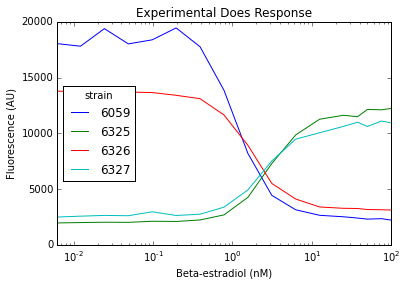

In [5]:
import pandas as pd

exp_dose = pd.read_csv(root_folder + "KlavinsLab/Projects/FSM/CSV/20150905_184902_CascadeDoseResponse_Final.csv")
AU = exp_dose['FL1.Amean']
treatment = exp_dose['treatment']
exp_dose = pd.pivot_table(exp_dose, index='treatment', columns=["strain"], values="FL1.Amean")
ax = exp_dose.plot(logx=True)
ax.set_xlabel("Beta-estradiol (nM)")
ax.set_ylabel("Fluorescence (AU)")
ax.set_title("Experimental Does Response")
ax
exp_dose

<h3>Import Kinetics Data</h3>

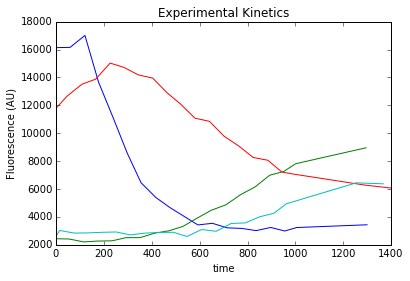

In [6]:
layers1 = pd.read_csv(root_folder + "KlavinsLab/projects/FSM/Analysis/KineticsData/Layer1.csv", header=None)
layers2 = pd.read_csv(root_folder + "KlavinsLab/projects/FSM/Analysis/KineticsData/Layer2.csv", header=None)
layers3 = pd.read_csv(root_folder + "KlavinsLab/projects/FSM/Analysis/KineticsData/Layer3.csv", header=None)
layers4 = pd.read_csv(root_folder + "KlavinsLab/projects/FSM/Analysis/KineticsData/Layer4.csv", header=None)


header = ['time', 'au']
layers1.columns = header
layers2.columns = header
layers3.columns = header
layers4.columns = header
layers1['layer'] = 1
layers2['layer'] = 2
layers3['layer'] = 3
layers4['layer'] = 4

#Triming kinetics data
ttrim = 1400
layers1 = layers1[layers1.time < ttrim]
layers2 = layers2[layers2.time < ttrim]
layers3 = layers3[layers3.time < ttrim]
layers4 = layers4[layers4.time < ttrim]

layers = pd.concat([layers1, layers2, layers3, layers4])
layers_table = pd.pivot_table(layers, values='au', columns=['layer'], index='time')
layers.sort(columns=['time', 'layer'])
layers['au'] = layers['au'] + 2000.
layers.stack()
layers
exp_kinetics = pd.pivot_table(layers, values='au', index=['layer', 'time'])
exp_kinetics
plt.figure()
plt.xlabel("Time (min)")
plt.ylabel("Fluorescence (AU)")
plt.title("Experimental Kinetics")
exp_kinetics[1].plot()
exp_kinetics[2].plot()
exp_kinetics[3].plot()
exp_kinetics[4].plot()
plt.show()
#exp_kinetics_trimed = exp_kinetics[exp_kinetics.time < 1200]
#exp_kinetics_trimed
trim_layer1 = exp_kinetics[1][exp_kinetics[1].index < 1400]
trim_layers = []
for i in range(1,5):
    trim_layer = exp_kinetics[i][exp_kinetics[i].index < 1400]
    trim_layers.append(trim_layer)
    trim_layer = pd.DataFrame(trim_layer)
    trim_layer['layer'] = i



<h2> Fitting </h2>

<h3> Scoring Function </h3>
$$χ^2_{red} = \frac{1}{v} \sum \frac{(O-E)^2}{σ^2} $$
$$ σ^2 \propto O^2 $$
$$ v = N - n - 1 $$
O is the observed data, E is the expected, and $σ^2$ is the covariance, which is estimated to be proporational to the square of the observed data. v is the degrees of freedom, N is the total number of experimental points, and n is the number of parameters.

I could either calculate chi-squared individually for each experiment and sum them (after normalization), or I could combine all points and calculate the chi-squared...

In [7]:
#imported data
#exp_kinetics
#exp_dose

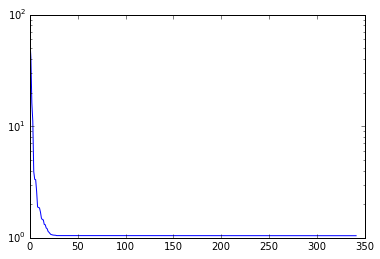

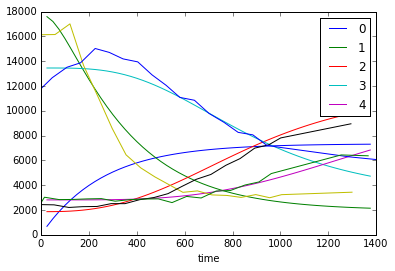

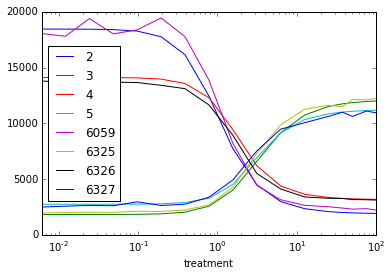

score         a                                       k            \
             0         0         1         2         3         0         1   
0    59.588167  0.844111  0.439122  0.339565  0.564541  0.469591  1.065560   
1    59.588167  0.844111  0.439122  0.339565  0.564541  0.469591  1.065560   
2    41.188010  0.689522  0.343670  0.972105  1.393739  0.737448  0.363280   
3    41.188010  0.689522  0.343670  0.972105  1.393739  0.737448  0.363280   
4    16.168519  0.822880  0.276526  0.220971  0.436871  1.050341  0.947832   
5    16.168519  0.822880  0.276526  0.220971  0.436871  1.050341  0.947832   
6    11.075464  1.102019  0.739731  1.303846  1.315022  0.462318  0.547977   
7    11.075464  1.102019  0.739731  1.303846  1.315022  0.462318  0.547977   
8     3.913588  1.244621  1.114995  0.980025  0.898378  0.721750  1.443665   
9     3.913588  1.244621  1.114995  0.980025  0.898378  0.721750  1.443665   
10    3.337972  1.267934  0.492977  0.883460  0.635019  1.417011  0.757054   
11    3.337972  1.267934  0.492977  0.883460  0.635019  1.417011  0.757054   
12    3.319814  1.384401  0.723099  0.709562  1.074382  0.995468  1.269941   
13    3.319814  1.384401  0.723099  0.709562  1.074382  0.995468  1.269941   
14    2.611089  1.169676  0.406186  0.514862  1.076846  1.486323  0.891027   
15    2.611089  1.169676  0.406186  0.514862  1.076846  1.486323  0.891027   
16    1.887498  1.297618  0.645574  0.773373  0.536299  0.925293  0.756626   
17    1.887498  1.297618  0.645574  0.773373  0.536299  0.925293  0.756626   
18    1.867832  1.231372  0.511349  0.719090  0.551616  0.942020  0.744137   
19    1.867832  1.231372  0.511349  0.719090  0.551616  0.942020  0.744137   
20    1.852374  1.153208  0.389357  0.568850  0.425278  1.057756  0.640644   
21    1.852374  1.153208  0.389357  0.568850  0.425278  1.057756  0.640644   
22    1.700938  1.219610  0.536880  0.745726  0.660315  0.688617  0.374271   
23    1.700938  1.219610  0.536880  0.745726  0.660315  0.688617  0.374271   
24    1.500908  1.226479  0.760830  0.834882  0.814892  0.716291  0.790913   
25    1.500908  1.226479  0.760830  0.834882  0.814892  0.716291  0.790913   
26    1.453507  1.185825  0.615675  0.702492  0.623482  0.620062  0.444573   
27    1.453507  1.185825  0.615675  0.702492  0.623482  0.620062  0.444573   
28    1.448760  1.243847  0.714205  0.763988  0.811882  0.665546  0.618456   
29    1.448760  1.243847  0.714205  0.763988  0.811882  0.665546  0.618456   
..         ...       ...       ...       ...       ...       ...       ...   
654   1.044209  1.079186  0.464538  0.575975  0.533618  0.689039  0.386974   
655   1.044209  1.079186  0.464538  0.575975  0.533618  0.689039  0.386974   
656   1.044209  1.079171  0.464543  0.575994  0.533615  0.689052  0.386979   
657   1.044209  1.079171  0.464543  0.575994  0.533615  0.689052  0.386979   
658   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
659   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
660   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
661   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
662   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
663   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
664   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
665   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
666   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
667   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
668   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
669   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
670   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
671   1.044209  1.079171  0.464543  0.575995  0.533615  0.689052  0.386979   
672   1.044209  1.079171  0.464

In [8]:
baseline = 2000.
au_scale = 1600.
t_scale = 25.0
import itertools
lowest_score = float('inf')
best_params = []
score_list_ss = []
score_list_k = []
score_list = []
params = [0] * 12


def fourlayer_scoring(prm):
    a = prm[:4]
    k = prm[4:8]
    b = prm[8:10]
    u = prm[10]
    n = prm[11]
    return scoring(a, k, b, np.array([u]*len(a)), n)

best_params_df = None

def scoreDose(a, k, b, u, n, num_params):
    params = [a, k, b, u, n]
    N_ss = np.sum(exp_dose.count())
    v = N_ss - num_params - 1
    sumsquares_ss = 0
    ss_model = ssModel(exp_dose.index, *params) * au_scale
    ss_model = ss_model.iloc[:,1:-1]
    ss_diff = np.subtract(exp_dose, ss_model)
    ss_diff = np.divide(ss_diff, 1000.0)
    sumsquares_ss = np.sum(np.square(ss_diff))
    chisquared_ss = np.sum(sumsquares_ss/v)
    return chisquared_ss, ss_model #+ chisquared_k
    

def scoreKinetics(a, k, b, u, n, num_params):
    params = [a, k, b, u, n]
    N_k = exp_kinetics.count()
    v = N_k - num_params - 1
    sumsquares_k = 0 #sum of squares
    
    kinetics_model = kineticsModel(*params) * au_scale
    kinetics_model = kinetics_model.set_index(kinetics_model.index * t_scale)
    layers = [exp_kinetics[i] for i in range(1,5)]
    layers_diff = []
    for i, layer in enumerate(layers):
        layer_model = []
        for t in layer.index:
            layer_model.append(getValue(t, kinetics_model)[1:])
        layer_model = pd.DataFrame(layer_model)[i+1]
        layer_diff = np.subtract(layer_model, layer)
        layer_diff = np.divide(layer_diff, 1000.0)
        sumsquares_k += np.sum(np.square(layer_diff))
    chisquared_k = sumsquares_k/v
    return chisquared_k, kinetics_model

def scoring(a, k, b, u, n):
    assert len(a) == len(k) == len(u)
    global lowest_score, best_params, best_params_df
    
    num_params = len(a) + len(k) + 3 + len(u) #num parameters
    
    b1, b2 = b
    params = [a, k, b1, b2, u, n]
    chiD, ss_model = scoreDose(a, k, b2, u, n, num_params)
    chiK, k_model = scoreKinetics(a, k, b1, u, n, num_params)
    chitotal = chiD + chiK
    paramkey = ['score', 'a', 'k', 'b', 'u', 'n']
    param_iter = {'score': 1, 'a':4, 'k':4, 'b':2, 'u':4, 'n':1}
    index = []
    for key in paramkey:
        index = index + zip([key]*param_iter[key], range(param_iter[key]))   
    index = pd.MultiIndex.from_tuples(index)

    
    if chitotal < lowest_score:
        score_list_ss.append(chitotal)
        best_params.append([chitotal] + params)
        
        display.clear_output(wait=True)
        #Plot score trajectory
        plt.plot(score_list_ss)
        plt.yscale('log')
        plt.show()

        #Plot kinetics model
        k_model.plot()
        exp_kinetics[1].plot()
        exp_kinetics[2].plot()
        exp_kinetics[3].plot()
        exp_kinetics[4].plot()
        plt.show()

        #Plot steady state model
        dose_combined = ss_model.join(exp_dose)
        dose_combined.plot(logx=True)
        plt.show()

        display.display(plt.gcf())
        
        #score_list_k.append(chisquared_k)
        best_params.append([chitotal] + params)
        lowest_score = chitotal
        
        
        paramlist = []
        for thisparam in best_params:
            score, a, k, b1, b2, u, n = thisparam
            paramlist.append([score] + list(a) + list(k) + [b1] + [b2] + list(u) + [n])
        best_params_df = pd.DataFrame(paramlist, columns=index)
        best_params_df.to_csv(root_folder + "KlavinsLab/Projects/FSM/Analysis/9-23-15_TruncatedKineticsData_9.csv")
        #p = pd.DataFrame(best_params)
        display.display(best_params_df)
    score_list.append(chitotal) 
    return chitotal

a_bounds = [(0.2, 1.5)] * 4
k_bounds = [(0.2, 1.5)] * 4
b_bounds = [(0.05, 0.13)] * 2
u_bounds = [(0.1, 0.6)] * 1
n_bounds = [(1.2, 1.7)] * 1
def getnewbounds(params, sd):
        bounds = []
        for p in params:
            bounds.append((p*sd, p/sd))
        return bounds
prms = [1.03574045,  1.18207634,  0.83243654,  1.27389883, 0.93279734,  1.1045275 ,  0.62765765,  1.46184243, 0.10799922120430067, 0.097911107046531429, 0.50175731,  0.555962  ,  0.44431392,  0.44665815, 1.4144877862709813]
bounds = a_bounds + k_bounds + b_bounds + u_bounds + n_bounds
#bounds = getnewbounds(prms, 1.0-0.2)
dt = 1.0
t_final = 55.0

res = optimize.differential_evolution(fourlayer_scoring, bounds, disp=True, popsize=100, mutation=(0.7, 1.0), recombination=0.7)
#%timeit scoring(a, k, b, u, n)

In [9]:
print best_params[-1]

[1.0442091174513195, array([ 1.07917111,  0.46454343,  0.57599446,  0.53361516]), array([ 0.68905206,  0.38697906,  0.34924508,  0.33527968]), 0.097564919069495562, 0.093598747439275251, array([ 0.44763113,  0.44763113,  0.44763113,  0.44763113]), 1.6089182621371305]


In [10]:
p = pd.DataFrame(best_params)
p.to_csv("/Users/Justin/Desktop/best_params_6.csv")
p

,0,1,2,3,4,5,6
0,59.588167,"[0.844111372046, 0.439122295562, 0.33956522654...","[0.469591358431, 1.06555980116, 1.31575783845,...",0.059869,0.129554,"[0.198191046557, 0.198191046557, 0.19819104655...",1.218813
1,59.588167,"[0.844111372046, 0.439122295562, 0.33956522654...","[0.469591358431, 1.06555980116, 1.31575783845,...",0.059869,0.129554,"[0.198191046557, 0.198191046557, 0.19819104655...",1.218813
2,41.188010,"[0.689521952904, 0.343670003521, 0.97210476513...","[0.737448275198, 0.363280101291, 0.32688427771...",0.076146,0.111106,"[0.149900396089, 0.149900396089, 0.14990039608...",1.360603
3,41.188010,"[0.689521952904, 0.343670003521, 0.97210476513...","[0.737448275198, 0.363280101291, 0.32688427771...",0.076146,0.111106,"[0.149900396089, 0.149900396089, 0.14990039608...",1.360603
4,16.168519,"[0.822879973106, 0.276525900177, 0.22097094923...","[1.05034097505, 0.947831650325, 0.222022651027...",0.115779,0.067074,"[0.300359317341, 0.300359317341, 0.30035931734...",1.667888
5,16.168519,"[0.822879973106, 0.276525900177, 0.22097094923...","[1.05034097505, 0.947831650325, 0.222022651027...",0.115779,0.067074,"[0.300359317341, 0.300359317341, 0.30035931734...",1.667888
6,11.075464,"[1.10201933201, 0.739731292124, 1.30384570257,...","[0.46231783754, 0.547976621592, 0.41648704727,...",0.098751,0.103468,"[0.510266772699, 0.510266772699, 0.51026677269...",1.546719
7,11.075464,"[1.10201933201, 0.739731292124, 1.30384570257,...","[0.46231783754, 0.547976621592, 0.41648704727,...",0.098751,0.103468,"[0.510266772699, 0.510266772699, 0.51026677269...",1.546719
8,3.913588,"[1.24462065035, 1.11499459311, 0.980025401275,...","[0.721750197639, 1.44366495957, 1.08199761251,...",0.108472,0.107263,"[0.568889825194, 0.568889825194, 0.56888982519...",1.305010
9,3.913588,"[1.24462065035, 1.11499459311, 0.980025401275,...","[0.721750197639, 1.44366495957, 1.08199761251,...",0.108472,0.107263,"[0.568889825194, 0.568889825194, 0.56888982519...",1.305010


In [11]:
dt = 0.01

In [12]:
for i in best_params[-1]:
    print i

1.04420911745
[ 1.07917111  0.46454343  0.57599446  0.53361516]
[ 0.68905206  0.38697906  0.34924508  0.33527968]
0.0975649190695
0.0935987474393
[ 0.44763113  0.44763113  0.44763113  0.44763113]
1.60891826214


<h1> Plotting Best Fits </h1>

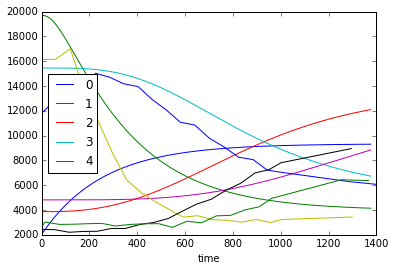

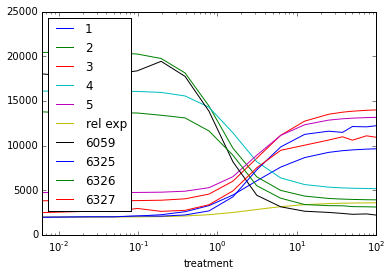

In [13]:
dt = 0.1

score, a, k, b1, b2, u, n = best_params[-1]
m = ssModel(exp_dose.index, a, k, b2, u, n) * 1600.0 + 2000.0
dose_combined = m.join(exp_dose)
k = kineticsModel(a, k, b1, u, n) * 1600.0 + 2000.0
k = k.set_index(k.index * 25.0)
k.plot()
exp_kinetics[1].plot()
exp_kinetics[2].plot()
exp_kinetics[3].plot()
exp_kinetics[4].plot()
dose_combined.plot(logx=True)

<h1> Saving Data </h1>

In [14]:
#steady state data
score, a, k, b1, b2, u, n = best_params[-1]
m = ssModel(0.006*2**np.linspace(0,20,1000), a, k, b1, u, n)
m_scaled = m.copy() * 1600.0 + 2000.0
m_scaled['rel exp'] = m['rel exp']
m_scaled.columns = ["Layer 1", "Layer 2 (6059)", "Layer 3 (6325)", "Layer 4 (6326)", "Layer 5 (6327)", "Relative Expression"]
m_scaled.index.rename("Be (nM)")
m_scaled.to_csv("/Users/Justin/Google Drive/KlavinsLab/Projects/FSM/Analysis/9-11-15_KineticsandSSFit/ss_model.csv")

#kinetics data
k = kineticsModel(a, k, b1, u, n) * 1600.0 + 2000.0
k = k.set_index(k.index * 25.0)
k.columns = ["Layer 1", "Layer 2 (6059)", "Layer 3 (6325)", "Layer 4 (6326)", "Layer 5 (6327)"]
k.index.rename("Time (min)")
k.to_csv("/Users/Justin/Google Drive/KlavinsLab/Projects/FSM/Analysis/9-11-15_KineticsandSSFit/kinetics_model.csv")

exp_dose.to_csv("/Users/Justin/Google Drive/KlavinsLab/Projects/FSM/Analysis/9-11-15_KineticsandSSFit/dose_response_experimental.csv")